<a href="https://colab.research.google.com/github/trevormoon/GAN_study/blob/main/GAN_Example.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [8]:
import numpy as np
from tensorflow.keras.datasets import mnist
from tensorflow.keras.layers import Input, Activation, Dense, Flatten, Reshape, Conv2D, Conv2DTranspose, Dropout, BatchNormalization, UpSampling2D
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
from tensorflow.keras.losses import mse
import matplotlib.pyplot as plt

(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train = (x_train.astype('float32')/255.0)*2.0-1.0 #[-1,1]구간
x_test = (x_test.astype('float32')/255.0)*2.0-1.0
x_train = np.reshape(x_train, (len(x_train), 28,28,1))
x_test = np.reshape(x_test, (len(x_test), 28,28,1))

batch_siz = 64
epochs = 5000
dropout_rate = 0.4
batch_norm = 0.9
zdim = 100 #잠복공간의 차원



In [9]:
discriminator_input = Input(shape=(28,28,1)) #분별망 D 설계
x= Conv2D(64,(5,5), activation = 'relu', padding = 'same', strides = (2,2))(discriminator_input)
x = Dropout(dropout_rate)(x)
x=Conv2D(64,(5,5), activation='relu', padding = 'same', strides=(2,2))(x)
x = Dropout(dropout_rate)(x)
x=Conv2D(128,(5,5), activation='relu', padding = 'same', strides=(2,2))(x)
x = Dropout(dropout_rate)(x)
x=Conv2D(128,(5,5), activation='relu', padding = 'same', strides=(1,1))(x)
x = Dropout(dropout_rate)(x)
x=Flatten()(x)
discriminator_output = Dense(1, activation = 'sigmoid')(x)
discriminator = Model(discriminator_input, discriminator_output)
discriminator.summary()


Model: "model_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_11 (InputLayer)       [(None, 28, 28, 1)]       0         
                                                                 
 conv2d_24 (Conv2D)          (None, 14, 14, 64)        1664      
                                                                 
 dropout_12 (Dropout)        (None, 14, 14, 64)        0         
                                                                 
 conv2d_25 (Conv2D)          (None, 7, 7, 64)          102464    
                                                                 
 dropout_13 (Dropout)        (None, 7, 7, 64)          0         
                                                                 
 conv2d_26 (Conv2D)          (None, 4, 4, 128)         204928    
                                                                 
 dropout_14 (Dropout)        (None, 4, 4, 128)         0  

In [10]:
generator_input = Input(shape=(zdim,))
x=Dense(3136)(generator_input)
x=BatchNormalization(momentum=batch_norm)(x)
x=Activation('relu')(x)
x=Reshape((7,7,64))(x)
x=UpSampling2D()(x)
x=Conv2D(128,(5,5),padding='same')(x)
x=BatchNormalization(momentum=batch_norm)(x)
x=Activation('relu')(x)
x=UpSampling2D()(x)
x=Conv2D(64,(5,5),padding='same')(x)
x=BatchNormalization(momentum=batch_norm)(x)
x=Activation('relu')(x)
x=Conv2D(64,(5,5),padding='same')(x)
x=BatchNormalization(momentum=batch_norm)(x)
x=Activation('relu')(x)
x=Conv2D(1,(5,5), activation='tanh',padding='same')(x)
generator_output= x
generator = Model(generator_input, generator_output)
generator.summary()

Model: "model_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_12 (InputLayer)       [(None, 100)]             0         
                                                                 
 dense_7 (Dense)             (None, 3136)              316736    
                                                                 
 batch_normalization_12 (Ba  (None, 3136)              12544     
 tchNormalization)                                               
                                                                 
 activation_12 (Activation)  (None, 3136)              0         
                                                                 
 reshape_3 (Reshape)         (None, 7, 7, 64)          0         
                                                                 
 up_sampling2d_6 (UpSamplin  (None, 14, 14, 64)        0         
 g2D)                                                     

1/1 [==============================] - 0s 18ms/step


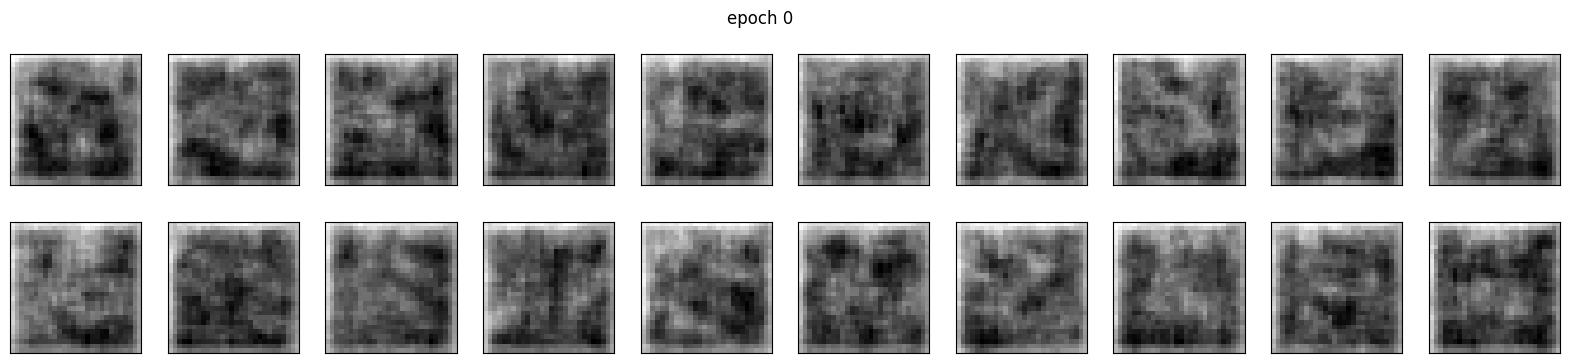

1/1 [==============================] - 0s 25ms/step


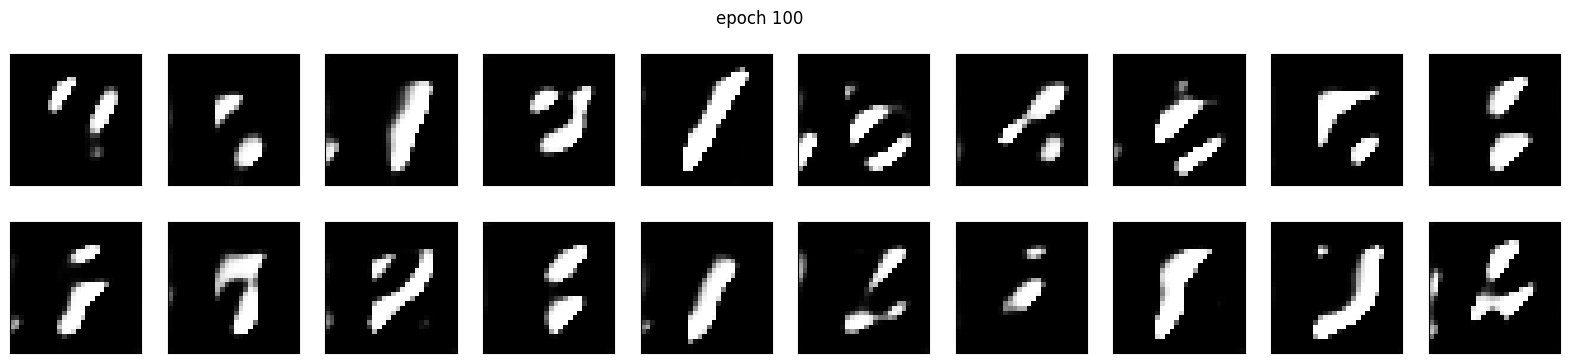

1/1 [==============================] - 0s 16ms/step


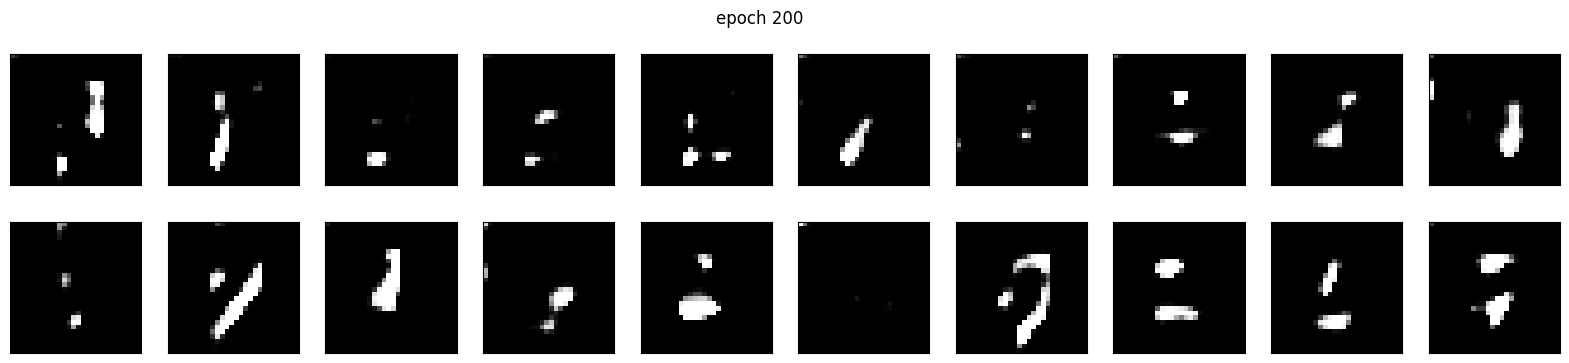

1/1 [==============================] - 0s 17ms/step


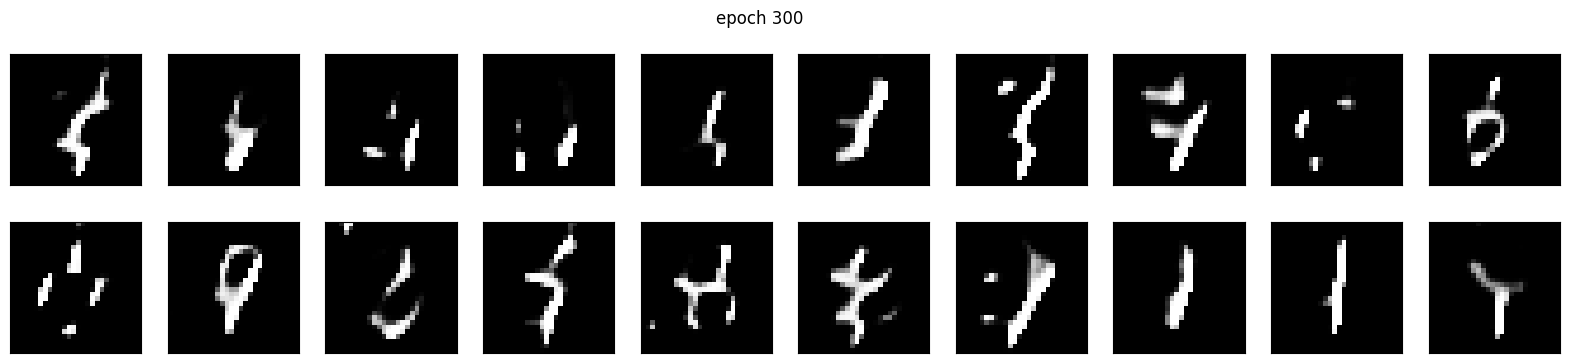

1/1 [==============================] - 0s 16ms/step


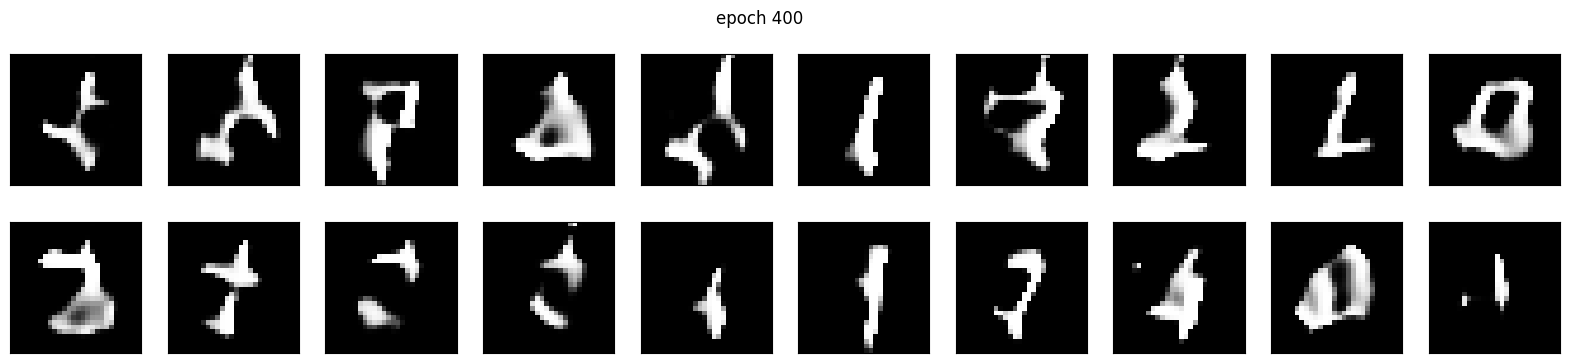

1/1 [==============================] - 0s 16ms/step


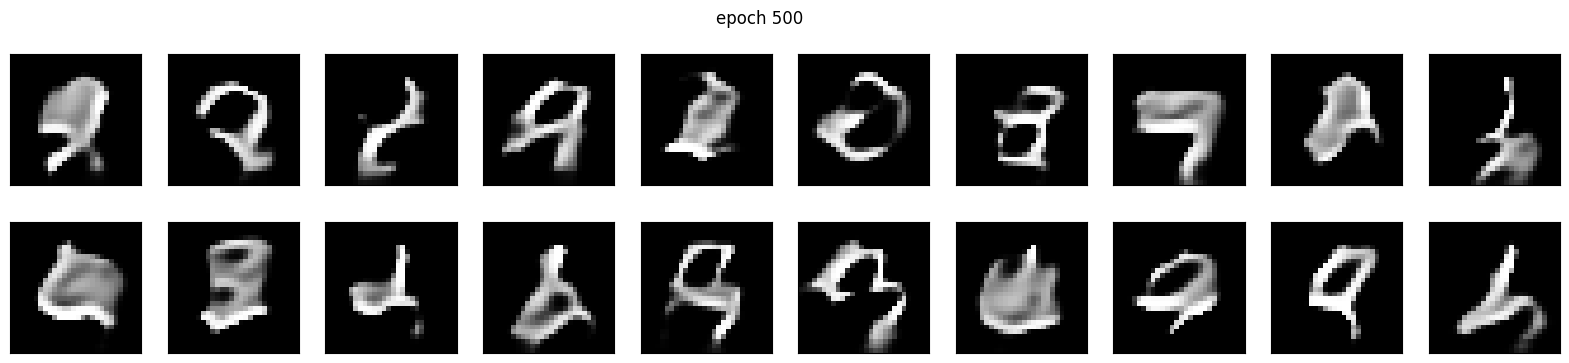

1/1 [==============================] - 0s 19ms/step


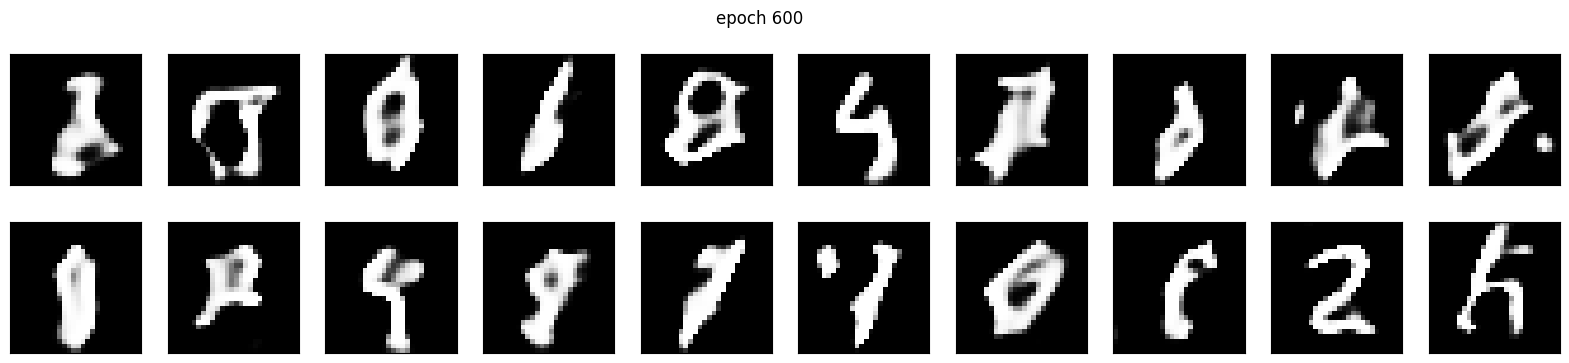

1/1 [==============================] - 0s 16ms/step


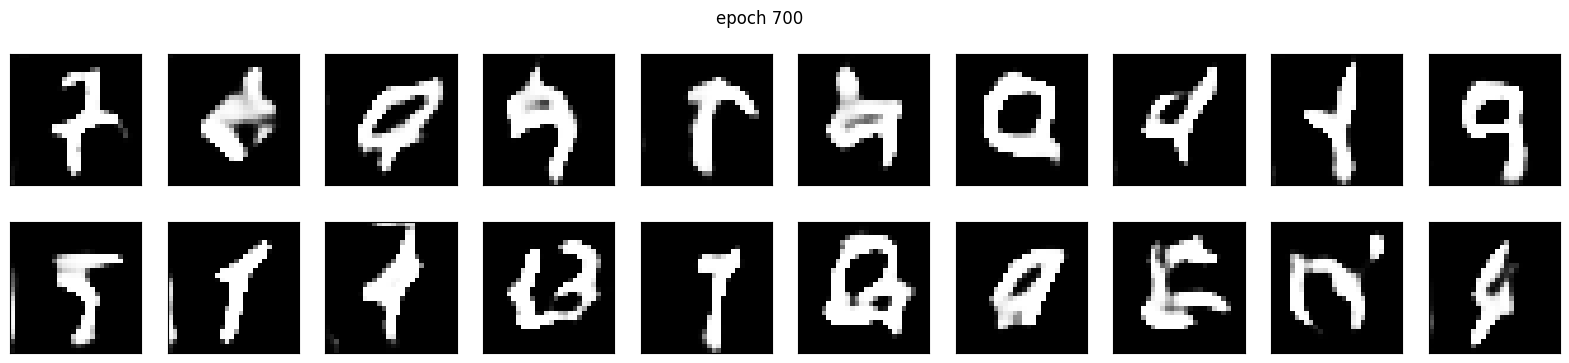

1/1 [==============================] - 0s 16ms/step


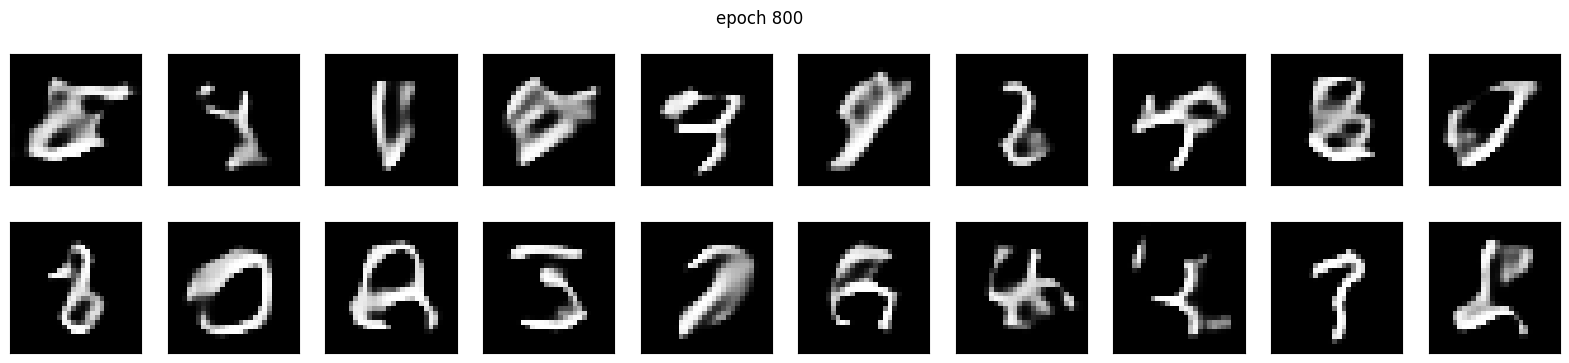

1/1 [==============================] - 0s 32ms/step


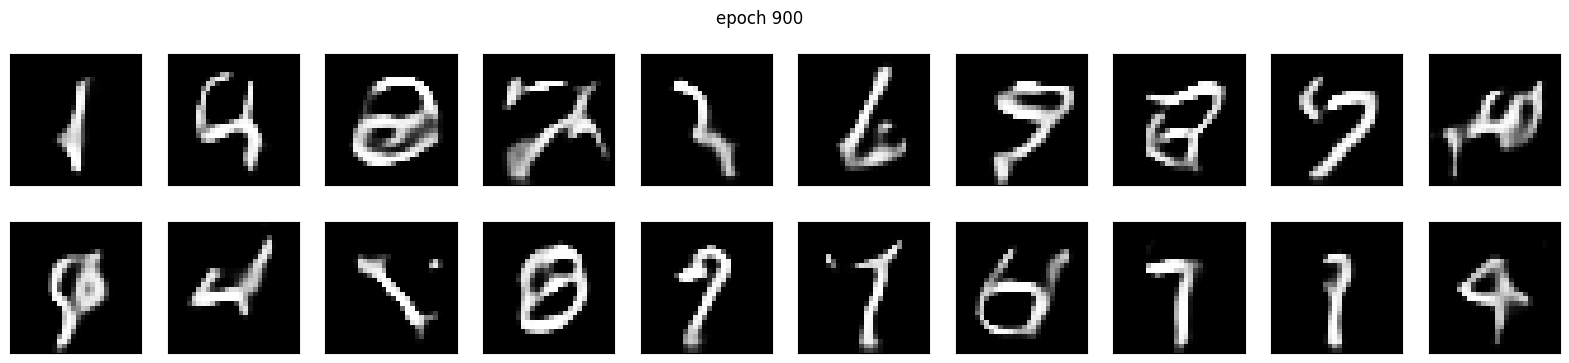

1/1 [==============================] - 0s 16ms/step


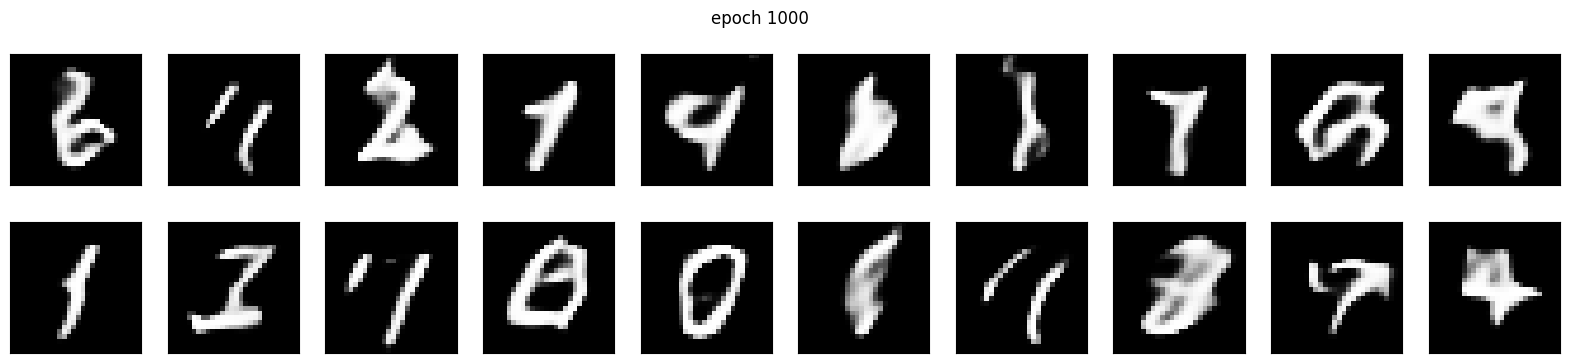

1/1 [==============================] - 0s 18ms/step


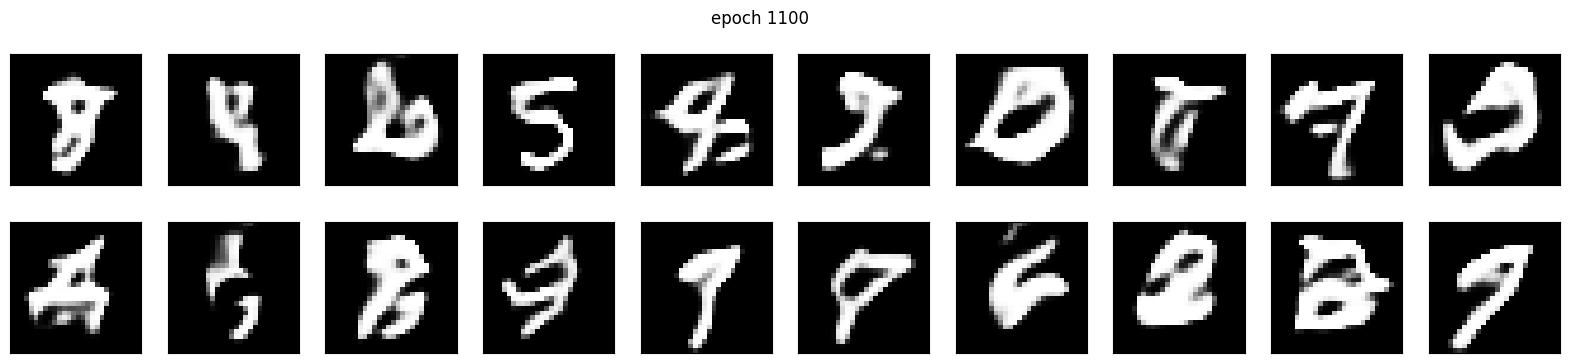

1/1 [==============================] - 0s 18ms/step


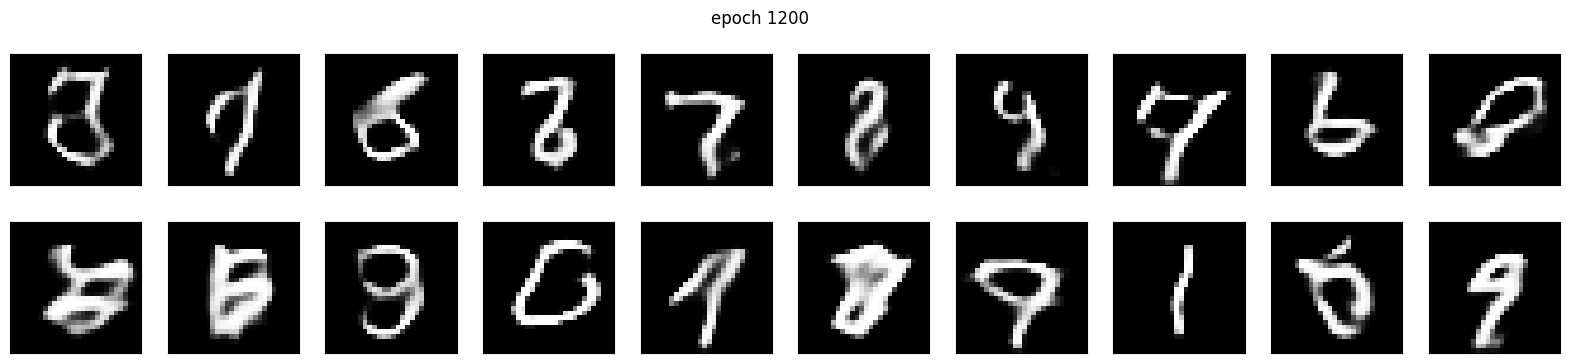

1/1 [==============================] - 0s 17ms/step


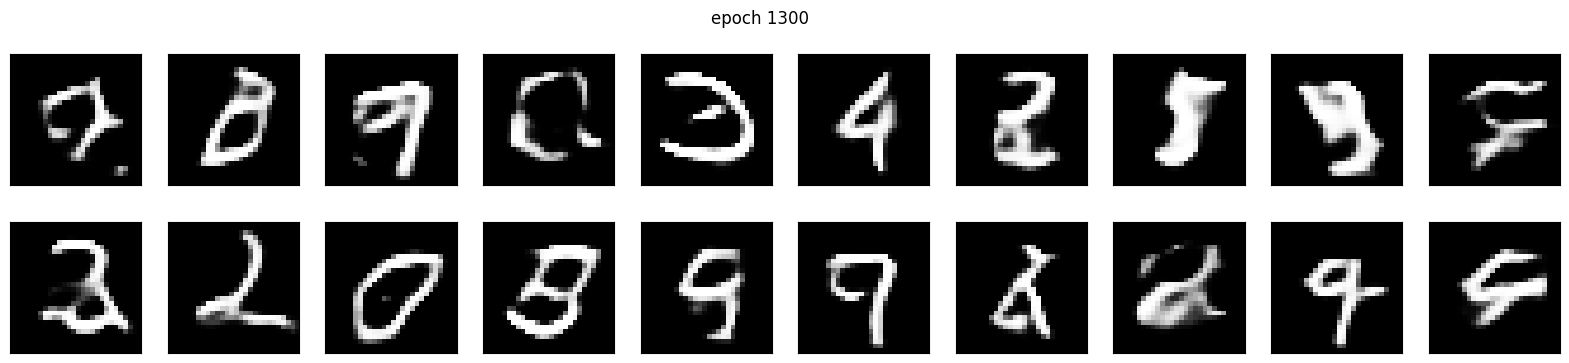

1/1 [==============================] - 0s 37ms/step


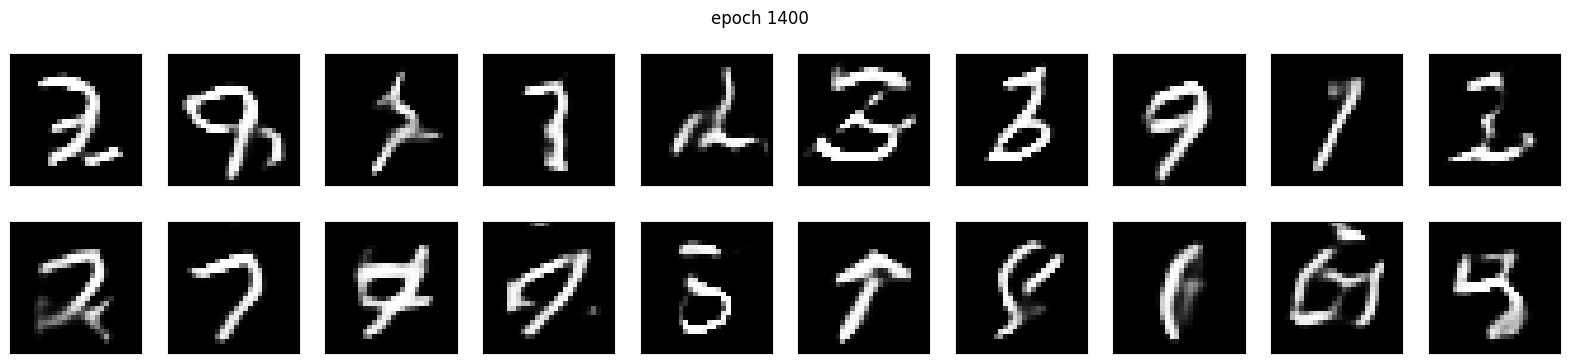

1/1 [==============================] - 0s 16ms/step


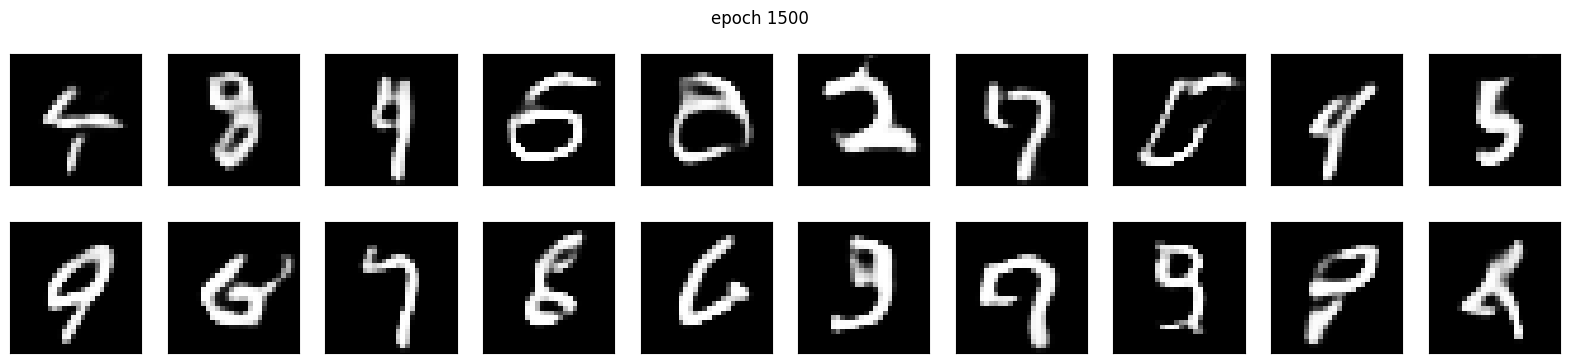

1/1 [==============================] - 0s 16ms/step


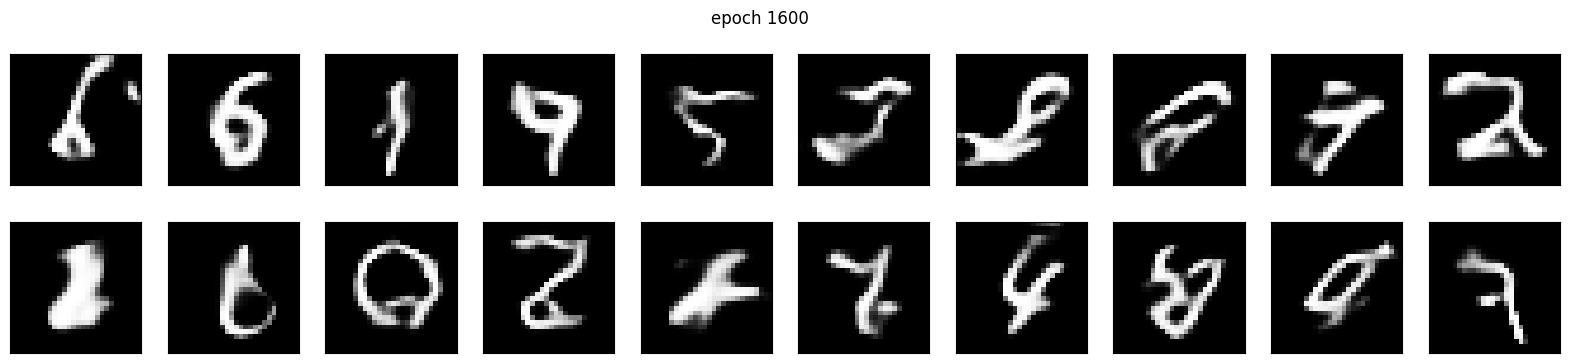

1/1 [==============================] - 0s 19ms/step


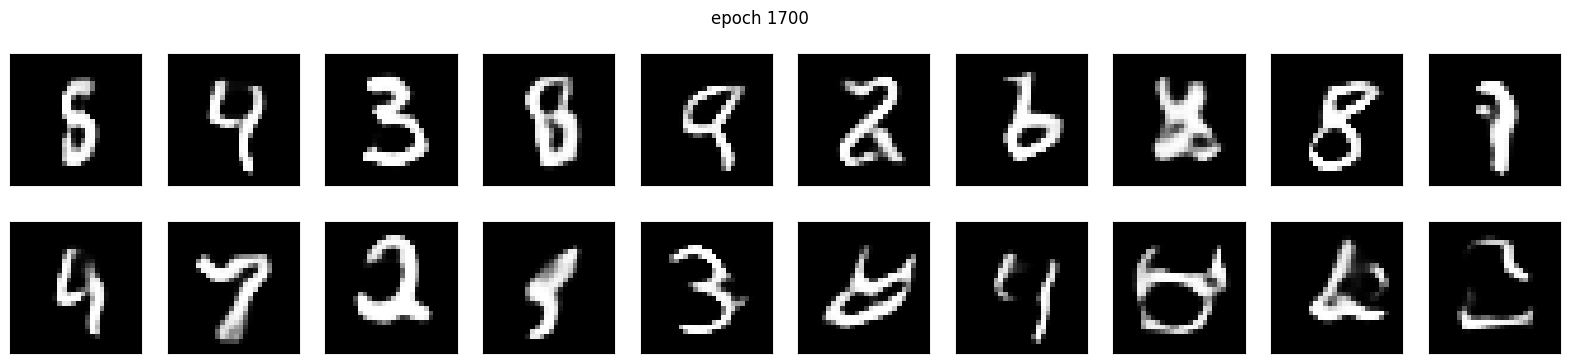

1/1 [==============================] - 0s 18ms/step


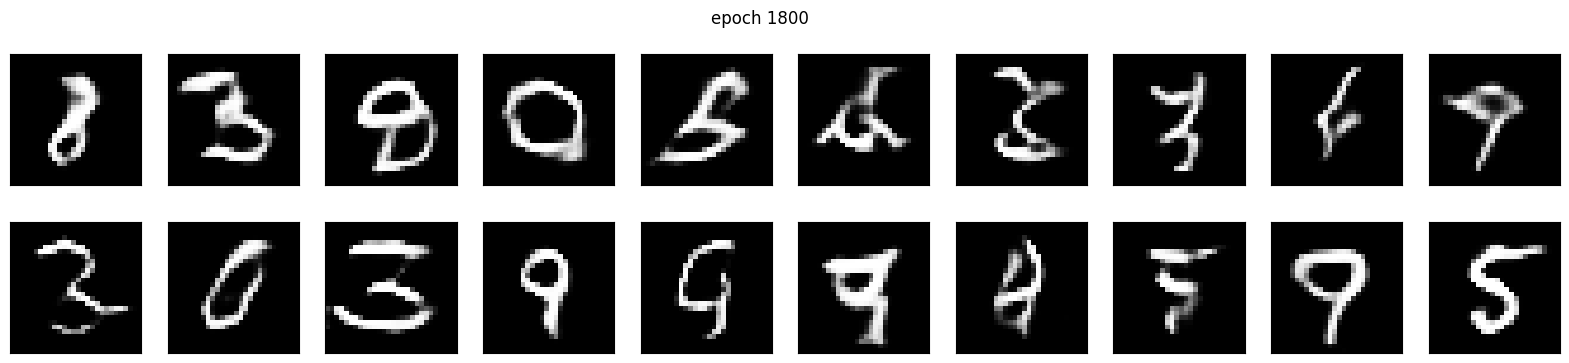

1/1 [==============================] - 0s 29ms/step


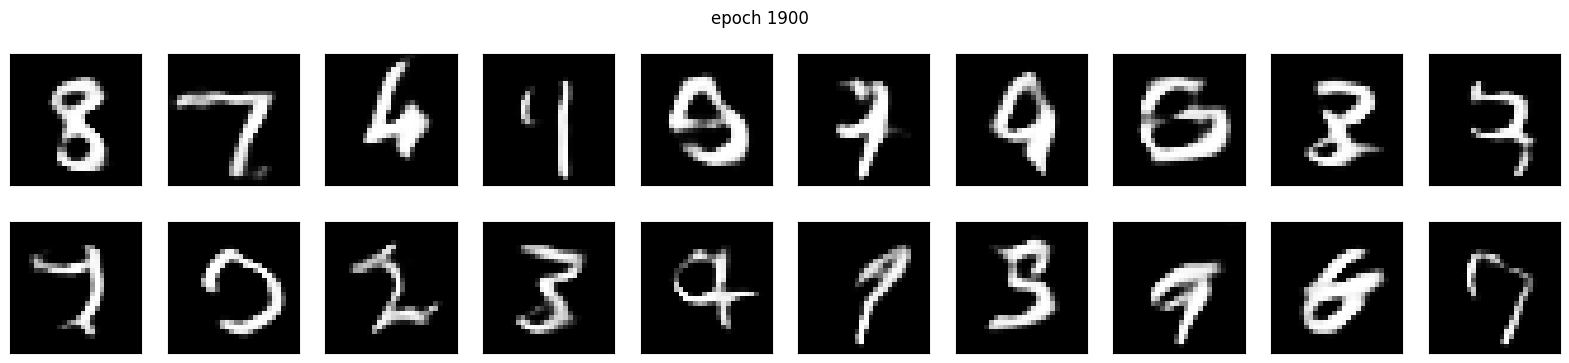

1/1 [==============================] - 0s 17ms/step


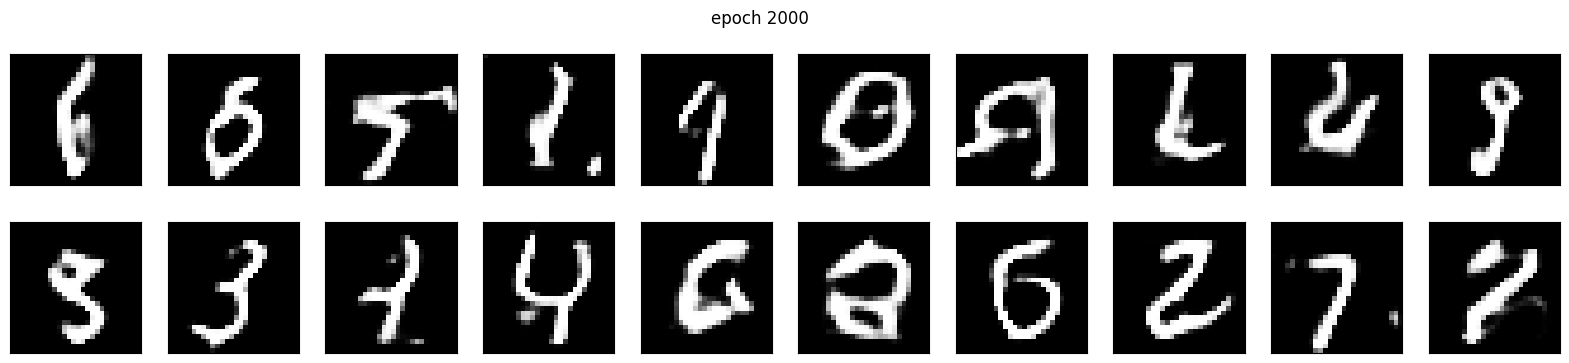

1/1 [==============================] - 0s 18ms/step


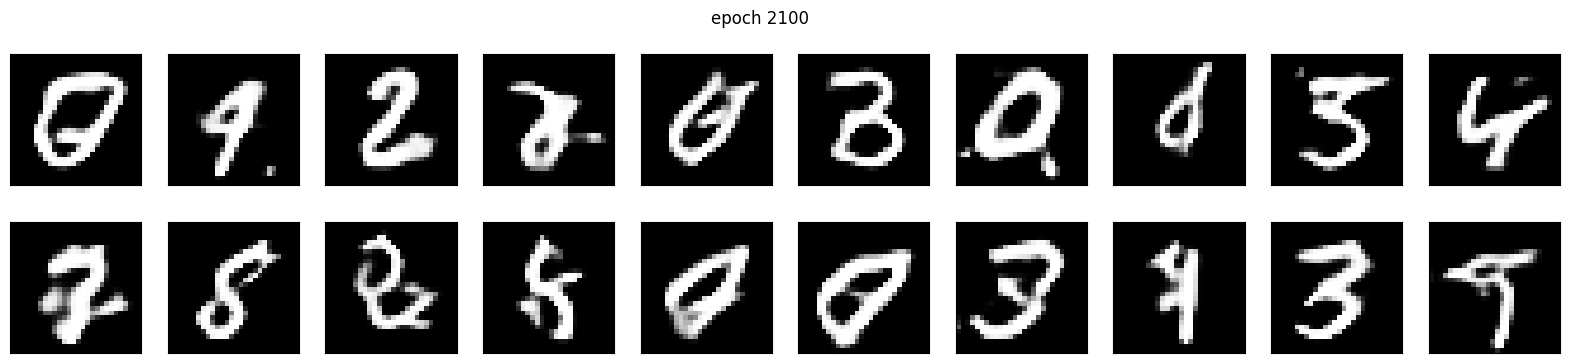

1/1 [==============================] - 0s 19ms/step


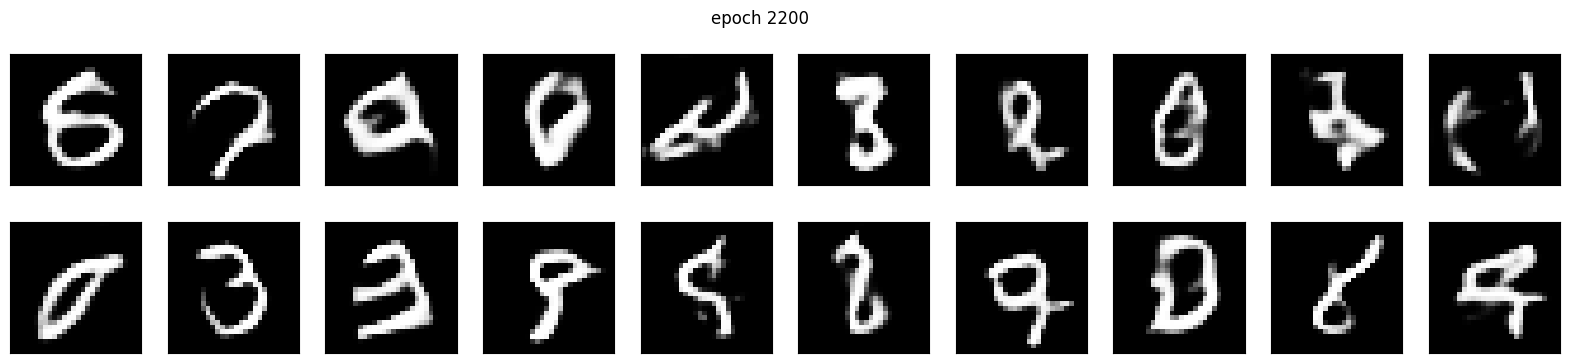

1/1 [==============================] - 0s 18ms/step


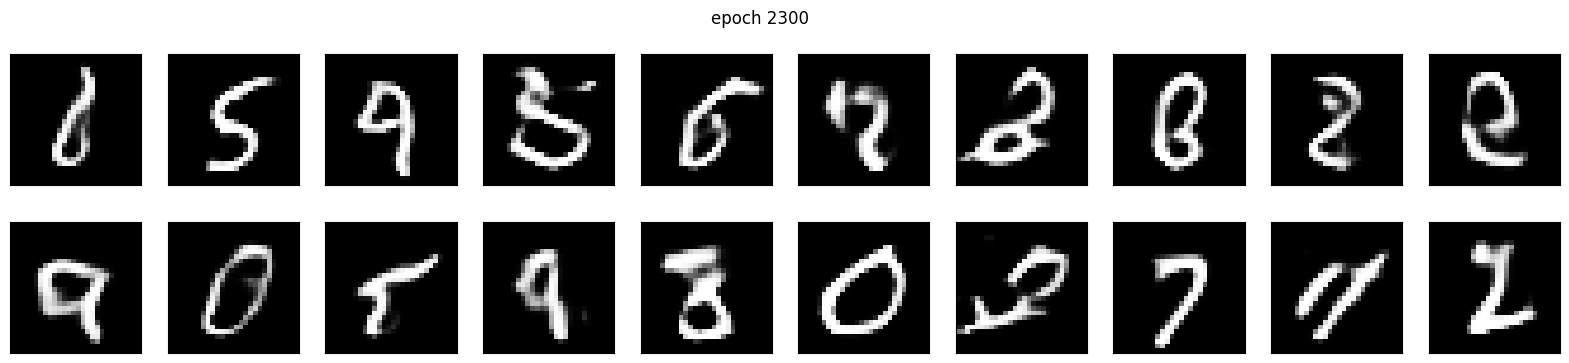

2/2 [==============================] - 0s 6ms/step


KeyboardInterrupt: 

In [11]:
discriminator.compile(optimizer='Adam', loss='binary_crossentropy', metrics = ['accuracy'])

discriminator.trainable = False
gan_input = Input(shape=(zdim,))
gan_output = discriminator(generator(gan_input))
gan = Model(gan_input, gan_output)
gan.compile(optimizer='Adam', loss='binary_crossentropy', metrics =['accuracy'])

def train_discriminator(x_train):
    c= np.random.randint(0, x_train.shape[0], batch_siz)
    real = x_train[c]
    discriminator.train_on_batch(real, np.ones((batch_siz,1)))

    p=np.random.normal(0,1, (batch_siz,zdim))
    fake = generator.predict(p)
    discriminator.train_on_batch(fake, np.zeros((batch_siz,1)))

def train_generator():
    p=np.random.normal(0,1, (batch_siz,zdim))
    gan.train_on_batch(p, np.ones((batch_siz,1)))

for i in range(epochs+1): # 학습을 수행
    train_discriminator(x_train)
    train_generator()
    if(i%100==0): # 학습 도중 100세대마다 중간 상황 출력
        plt.figure(figsize=(20, 4))
        plt.suptitle('epoch '+str(i))
        for k in range(20):
            plt.subplot(2,10,k+1)
            img=generator.predict(np.random.normal(0,1,(1,zdim)))
            plt.imshow(img[0].reshape(28,28),cmap='gray')
            plt.xticks([]); plt.yticks([])
        plt.show()

imgs = generator.predcit(np.random.normal(0,1,(50,zdim)))
plt.figure(figsize=(20,10))
for i in range(50):
    plt.subplot(5,10,i+1)
    plt.imshow(imgs[i].reshape(28,28), cmap='gray')
    plt.xticks([]);plt.yticks([])